In [173]:
import pandas as pd
import duckdb
import json
import warnings

In [172]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [174]:
import plotly.graph_objects as go
import plotly.express as px

In [162]:
conn = duckdb.connect('secrets/cws_data.db')

In [143]:
conn.close()

In [164]:
def query(query_string, df=False, conn=conn):
    if df==True:
        return conn.sql(query_string).df()
    else:
        return conn.sql(query_string).show()

## EDA

In [206]:
# accepted proposals

conn.sql("""
CREATE OR REPLACE VIEW accepted_proposals AS
SELECT
    p.year,
    p.category,
    p.proposal
FROM
    proposals p
    LEFT JOIN rejects r
    ON p.year = r.year AND p.proposal = r.proposal
WHERE 
    r.proposal IS NULL 
    AND category NOT IN ('Untranslated', 'Larger_suggestions')
""")

In [213]:
all_proposals = conn.sql("""
WITH
    base AS (
        SELECT
            *,
            'no_err' AS error
        FROM
            proposals
        UNION ALL
        SELECT
            *
        FROM
            errors
    )

SELECT
    year,
    COUNT(DISTINCT proposal) AS all_proposals,
    COUNT(DISTINCT CASE WHEN NOT error = 'no_err' THEN proposal END) AS all_errors
FROM
    base
GROUP BY
    year
ORDER BY
    year
""").df()

all_proposals['perc_errors_all'] = round(all_proposals['all_errors'] / all_proposals['all_proposals'] * 100, 2)
all_proposals

,year,all_proposals,all_errors,perc_errors_all
0,2015,107,0,0.00
1,2016,265,0,0.00
2,2017,329,6,1.82
3,2019,347,15,4.32
4,2020,122,4,3.28
5,2021,453,25,5.52
6,2022,467,16,3.43
7,2023,272,8,2.94


In [205]:
round(all_proposals.all_errors.sum() / all_proposals.all_proposals.sum() * 100, 2)

3.13

In [214]:
acc_proposals = conn.sql("""
WITH
    base AS (
        SELECT
            *,
            'no_err' AS error
        FROM
            accepted_proposals
        UNION ALL
        SELECT
            *
        FROM
            errors
    )

SELECT
    year,
    COUNT(DISTINCT proposal) AS accepted_proposals,
    COUNT(DISTINCT CASE WHEN NOT error = 'no_err' AND NOT category IN ('Archive', 'Large_suggestions') THEN proposal END) AS non_archive_errors
FROM
    base
GROUP BY
    year
ORDER BY
    year
""").df()

acc_proposals['perc_errors_acc'] = round(acc_proposals['non_archive_errors'] / acc_proposals['accepted_proposals'] * 100, 2)
acc_proposals

,year,accepted_proposals,non_archive_errors,perc_errors_acc
0,2015,107,0,0.00
1,2016,265,0,0.00
2,2017,219,1,0.46
3,2019,224,2,0.89
4,2020,76,0,0.00
5,2021,292,1,0.34
6,2022,279,8,2.87
7,2023,188,3,1.60


In [209]:
round(acc_proposals.non_archive_errors.sum() / acc_proposals.accepted_proposals.sum() * 100, 2)

0.91

## Wishlist Process
- Overall Proposals
- Categories Over Years
    - Proposals
    - Participation Trends

In [217]:
proposals_summary = pd.merge(all_proposals, acc_proposals, on='year')
proposals_summary['rejection_rate'] = round((1 - proposals_summary['accepted_proposals'] /  proposals_summary['all_proposals']) * 100, 2)
proposals_summary

,year,all_proposals,all_errors,perc_errors_all,accepted_proposals,non_archive_errors,perc_errors_acc,rejection_rate
0,2015,107,0,0.00,107,0,0.00,0.00
1,2016,265,0,0.00,265,0,0.00,0.00
2,2017,329,6,1.82,219,1,0.46,33.43
3,2019,347,15,4.32,224,2,0.89,35.45
4,2020,122,4,3.28,76,0,0.00,37.70
5,2021,453,25,5.52,292,1,0.34,35.54
6,2022,467,16,3.43,279,8,2.87,40.26
7,2023,272,8,2.94,188,3,1.60,30.88


In [224]:
print(f'rejection rate: {round(proposals_summary.query("""year >= 2017""").rejection_rate.mean())}%')

rejection rate: 36%


## categories by year

In [179]:
all_categories_by_year = query("""
WITH 
    base AS (
        SELECT 
            *, 
            NULL AS error 
        FROM 
            accepted_proposals
        UNION ALL
        SELECT 
            * 
        FROM 
            errors),

    yearly AS (
        SELECT
            year, 
            category, 
            COUNT(DISTINCT proposal) AS proposals 
        FROM 
            base
        WHERE
            NOT category IN ('Archive', 'Larger_suggestions', 'Untranslated')
        GROUP BY 
            year, 
            category)

PIVOT yearly
ON category
USING SUM(proposals)
GROUP BY year""", True).fillna(0).astype(int)

all_categories_by_year

,year,Anti-harassment,Bots_and_gadgets,Citations,Communication_tools,Editing,Maps,Miscellaneous,Mobile_and_apps,Moderation_tools,Multimedia_and_Commons,Navigation_tools,New_contributors,Programs_and_events,Reading,Templates,Translation,Watchlists,WikiProjects,Wikibooks,Wikidata,Wikinews,Wikiquote,Wikisource,Wikispecies,Wikiversity,Wikivoyage,Wiktionary
0,2015,0,4,0,9,13,0,17,0,13,11,12,0,0,4,3,0,7,0,0,7,0,0,6,0,1,0,0
1,2016,0,13,6,0,34,0,34,10,22,44,11,0,7,10,0,0,24,2,0,26,0,0,18,0,0,0,4
2,2017,3,10,5,0,25,0,27,18,13,29,8,0,2,13,0,0,15,0,0,29,0,0,9,0,0,0,8
3,2019,4,10,13,4,27,13,17,12,15,20,18,0,2,8,0,0,12,0,0,19,0,0,11,0,0,0,7
4,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,3,28,1,11,4,20
5,2021,3,15,12,7,39,0,27,18,25,31,21,0,0,13,0,10,17,0,0,21,0,0,5,0,0,0,4
6,2022,11,13,11,6,34,0,39,17,11,27,18,0,0,14,0,15,10,0,0,26,0,0,11,0,0,0,7
7,2023,9,10,5,15,21,0,20,3,16,27,8,3,0,11,0,8,0,0,0,14,0,0,6,0,0,0,6


In [148]:
viz_categories = pd.DataFrame(all_categories_by_year.sum(axis=0, min_count=2)).dropna().index.values
categories_by_year = all_categories_by_year[viz_categories]
categories_by_year = categories_by_year.fillna(0).astype(int)
categories_by_year

,year,Anti-harassment,Bots_and_gadgets,Citations,Communication_tools,Editing,Larger_suggestions,Miscellaneous,Mobile_and_apps,Moderation_tools,Multimedia_and_Commons,Navigation_tools,Programs_and_events,Reading,Translation,Watchlists,Wikidata,Wikisource,Wiktionary
0,2015,0,4,0,9,13,0,17,0,13,11,12,0,4,0,7,7,6,0
1,2016,0,13,6,0,34,0,34,10,22,44,11,7,10,0,24,26,18,4
2,2017,4,15,8,0,48,0,47,21,22,45,9,4,16,0,23,40,11,9
3,2019,5,13,15,4,46,0,49,19,20,31,22,4,12,0,14,32,14,10
4,2021,10,24,14,9,75,0,44,30,31,45,33,6,28,10,22,26,6,6
5,2022,14,23,19,9,52,57,54,24,17,36,31,0,24,17,13,29,14,9
6,2023,9,13,6,17,31,30,28,4,18,33,12,0,12,9,0,17,7,7


In [75]:
# voting and participation by category

In [ ]:
categories_by_year

## roles by year

In [149]:
roles_by_year = conn.sql("""
SELECT
    ap.year,
    role,
    COUNT(DISTINCT username) AS users
FROM
    accepted_proposals ap
    JOIN roles rl ON ap.year = rl.year AND ap.proposal = rl.proposal
GROUP BY
    ap.year,
    role
ORDER BY
    ap.year,
    role

""").df()

In [150]:
roles_by_year

,year,role,users
0,2015,discussant,195
1,2015,proposer,79
2,2015,voter,534
3,2016,discussant,370
4,2016,proposer,163
5,2016,voter,891
6,2017,discussant,362
7,2017,proposer,147
8,2017,voter,975
9,2019,discussant,480


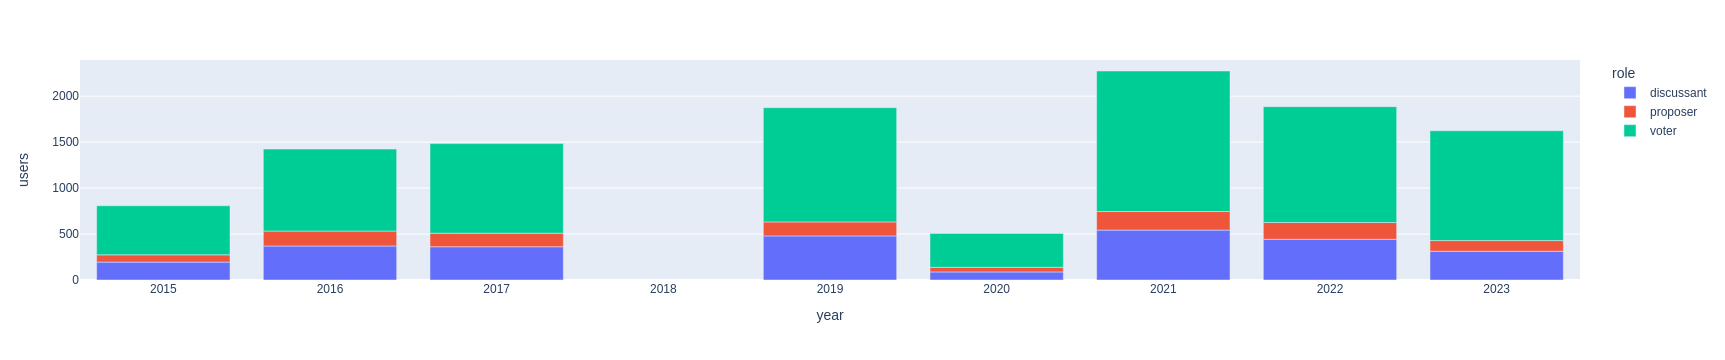

In [151]:
fig = px.bar(roles_by_year, x='year', y='users', color='role')
fig.show()

## proposals over years
- proposals by year
- proposals by category over year
    - with rejects and without rejects
- voting trends by category
- unique voters by category

In [152]:
# voting trend



In [ ]:
conn.sql("""SELECT year""")

### home wiki spread
understand what is the home wiki by year for different roles

In [139]:
conn.sql("""
CREATE OR REPLACE VIEW ud_merge AS
SELECT
    ap.*,
    role,
    r.username,
    home_wiki,
    hw_user_groups::MAP(INT, VARCHAR) AS hw_user_groups,
    edit_bucket,
    account_age
FROM
    accepted_proposals ap
    JOIN roles r ON ap.year = r.year AND ap.proposal = r.proposal
    JOIN user_data ud ON r.year = ud.year AND r.username = ud.username
""")

In [97]:
conn.sql("""
CREATE OR REPLACE VIEW hw_spread AS
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY year, role) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY year, role ORDER BY users DESC) AS rank
FROM
    (       SELECT
            year,
            role,
            home_wiki,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            year,
            home_wiki,
            role)
""")

## edit bucket on homewiki

In [114]:
query("""
CREATE OR REPLACE VIEW hw_edit_bucket_spread AS
SELECT
    *,
    ROUND(users / SUM(users) OVER (PARTITION BY year, role) * 100, 2) AS perc,
    ROW_NUMBER() OVER (PARTITION BY year, role ORDER BY users DESC) AS rank
FROM
    (       SELECT
            year,
            role,
            home_wiki,
            COUNT(DISTINCT username) AS users
        FROM
            ud_merge
        GROUP BY
            year,
            home_wiki,
            role)
""", True)

,year,role,edit_bucket,users
0,2020,voter,5000+,272
1,2020,voter,0-99,18
2,2020,voter,1000-4999,51
3,2020,proposer,5000+,36
4,2020,discussant,5000+,70
...,...,...,...,...
78,2017,proposer,100-499,1
79,2019,voter,0-99,19
80,2019,discussant,0-99,14
81,2020,proposer,100-499,1


In [ ]:
query("""SELECT * FROM user_data LIMIT 5""", True)

,year,username,home_wiki,hw_user_groups,edit_count,edit_bucket,account_age
0,2015,AshLin,enwiki,"['autoreviewer', 'extendedconfirmed', 'reviewe...","{'hw': 27961.0, 'mw': 286.0}","{'hw': '5000+', 'mw': '100-499'}","{'months': 174, 'years': 14.5}"
1,2015,BernardP,enwiki,"['autoreviewer', 'extendedconfirmed', 'reviewer']","{'hw': 3656.0, 'mw': 1.0}","{'hw': '1000-4999', 'mw': '0-99'}","{'months': 102, 'years': 8.5}"
2,2015,Jan.Kamenicek,enwiktionary,['autopatrolled'],"{'hw': 4214.0, 'mw': 41.0}","{'hw': '1000-4999', 'mw': '0-99'}","{'months': 184, 'years': 15.33}"
3,2015,Ekkt0r,enwiki,['extendedconfirmed'],"{'hw': 534.0, 'mw': 2.0}","{'hw': '5000+', 'mw': '0-99'}","{'months': 121, 'years': 10.08}"
4,2015,Ham II,commonswiki,"['autopatrolled', 'filemover']","{'hw': 37429.0, 'mw': 98.0}","{'hw': '5000+', 'mw': '0-99'}","{'months': 105, 'years': 8.75}"


## users rights on homewiki

In [145]:
query("""SELECT * FROM ud_merge WHERE list_contains(hw_user_groups, 'autopatrolled')""", True)

ConnectionException: Connection Error: Connection has already been closed

In [142]:
query("""DESCRIBE ud_merge""")

┌────────────────┬───────────────────────────────────────────┬─────────┬─────────┬─────────┬───────┐
│  column_name   │                column_type                │  null   │   key   │ default │ extra │
│    varchar     │                  varchar                  │ varchar │ varchar │ varchar │ int32 │
├────────────────┼───────────────────────────────────────────┼─────────┼─────────┼─────────┼───────┤
│ year           │ INTEGER                                   │ YES     │ NULL    │ NULL    │  NULL │
│ category       │ VARCHAR                                   │ YES     │ NULL    │ NULL    │  NULL │
│ proposal       │ VARCHAR                                   │ YES     │ NULL    │ NULL    │  NULL │
│ role           │ VARCHAR                                   │ YES     │ NULL    │ NULL    │  NULL │
│ username       │ VARCHAR                                   │ YES     │ NULL    │ NULL    │  NULL │
│ home_wiki      │ VARCHAR                                   │ YES     │ NULL    │ NULL    

## user account age (global)

## edit bucket on meta wiki

## cross-proposal enagement


## how many new people join

## patterns
- repetition of proposers and voters
- cross proposal engagement by year